In [1]:
import tensorflow as tf
import os
import numpy as np
import glob
import random
import cv2
from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, BatchNormalization,Conv2DTranspose, concatenate,Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
from keras import backend as K


In [2]:
data_folder = r"C:\Users\Desktop\veri"

In [3]:
train_folder = os.path.join(data_folder, "train")
test_folder = os.path.join(data_folder, "test")
validation_folder = os.path.join(data_folder, "validation")

In [4]:
#####Train
train_data = []
train_mask = []

for patient_folder in glob.glob(os.path.join(train_folder, "patient")):
    image_folder = os.path.join(patient_folder, "image")
    mask_folder = os.path.join(patient_folder, "mask")

    # image ve mask dosyalarını sırayla eşleştir
    for image_path, mask_path in zip(glob.glob(os.path.join(image_folder, "*.png")),
                                     glob.glob(os.path.join(mask_folder, "*.png"))):
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        train_data.append(image)
        train_mask.append(mask)

# Veri --> numpy
train_data = np.array(train_data, dtype=object)
train_mask = np.array(train_mask, dtype=object)

#####Test
test_data = []
test_mask = []

for patient_folder in glob.glob(os.path.join(test_folder, "patient")):
    image_folder = os.path.join(patient_folder, "image")
    mask_folder = os.path.join(patient_folder, "mask")

    # image ve mask dosyalarını sırayla eşleştir
    for image_path, mask_path in zip(glob.glob(os.path.join(image_folder, "*.png")),
                                     glob.glob(os.path.join(mask_folder, "*.png"))):
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        test_data.append(image)
        test_mask.append(mask)

# Veri --> numpy
test_data = np.array(test_data, dtype=object)
test_mask = np.array(test_mask, dtype=object)

#####Validation
validation_data = []
validation_mask = []

for patient_folder in glob.glob(os.path.join(validation_folder, "patient")):
    image_folder = os.path.join(patient_folder, "image")
    mask_folder = os.path.join(patient_folder, "mask")

    for image_path in glob.glob(os.path.join(image_folder, "*.png")):
        image = cv2.imread(image_path)
        validation_data.append(image)

    for mask_path in glob.glob(os.path.join(mask_folder, "*.png")):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        validation_mask.append(mask)

# Veri --> numpy
validation_data = np.array(validation_data, dtype=object)
validation_mask = np.array(validation_mask, dtype=object)


print("Eğitim verilerinin boyutu:", train_data.shape)
print("Eğitim maskelerinin boyutu:", train_mask.shape)
print("Test verilerinin boyutu:", test_data.shape)
print("Test maskelerinin boyutu:", test_data.shape)
print("validation verilerinin boyutu:", validation_data.shape)
print("validation maskelerinin boyutu:", validation_mask.shape)

Eğitim verilerinin boyutu: (1944,)
Eğitim maskelerinin boyutu: (1944,)
Test verilerinin boyutu: (282,)
Test maskelerinin boyutu: (282,)
validation verilerinin boyutu: (283,)
validation maskelerinin boyutu: (283,)


# Normalizasyon ve Reshape


In [5]:
new_width = 128
new_height = 128

#Train

resized_train_data = []
for image in train_data:
    resized_image = cv2.resize(image, (new_width, new_height))
    normalized_image = resized_image / 255.0  # 0-255 arası piksel değerlerini 0-1 arasına dönüştür
    resized_train_data.append(normalized_image)

resized_train_data = np.array(resized_train_data)

resized_train_mask = []
for mask in train_mask:
    resized_mask = cv2.resize(mask, (new_width, new_height))
    resized_mask = resized_mask/255.0
    resized_train_mask.append(resized_mask)
resized_train_mask = np.array(resized_train_mask)

resized_train_mask = resized_train_mask.reshape(-1, 128, 128, 1)
print("Yeniden boyutlandırılmış ve normalleştirilmiş eğitim verilerinin boyutu:", resized_train_data.shape)
print("Yeniden boyutlandırılmış ve normalleştirilmiş eğitim maske verilerinin boyutu:", resized_train_mask.shape)

#Test

resized_test_data = []

for image in test_data:
    resized_image = cv2.resize(image, (new_width, new_height))
    normalized_image = resized_image / 255.0  # 0-255 arası piksel değerlerini 0-1 arasına dönüştür
    resized_test_data.append(normalized_image)

resized_test_data = np.array(resized_test_data)

resized_test_mask = []

for mask in test_mask:
    resized_mask = cv2.resize(mask, (new_width, new_height))
    resized_mask = resized_mask / 255.0
    resized_test_mask.append(resized_mask)

resized_test_mask = np.array(resized_test_mask)
resized_test_mask = resized_test_mask.reshape(-1, new_width, new_height, 1)
print("Yeniden boyutlandırılmış ve normalleştirilmiş test verilerinin boyutu:", resized_test_data.shape)
print("Yeniden boyutlandırılmış ve normalleştirilmiş test maske verilerinin boyutu:", resized_test_mask.shape)

#Validation

resized_validation_data = []
for image in validation_data:
    resized_image = cv2.resize(image, (new_width, new_height))
    normalized_image = resized_image / 255.0  # 0-255 arası piksel değerlerini 0-1 arasına dönüştür
    resized_validation_data.append(normalized_image)

resized_validation_data = np.array(resized_validation_data)

resized_validation_mask = []
for mask in validation_mask:
    resized_mask = cv2.resize(mask, (new_width, new_height))
    normalized_mask = resized_mask / 255.0
    resized_validation_mask.append(normalized_mask)
resized_validation_mask = np.array(resized_validation_mask)
resized_validation_mask = resized_validation_mask.reshape(-1, new_width, new_height, 1)

print("Yeniden boyutlandırılmış ve normalleştirilmiş validation  verilerinin boyutu:", resized_validation_data.shape)
print("Yeniden boyutlandırılmış ve normalleştirilmiş validation  maske verilerinin boyutu:", resized_validation_mask.shape)


Yeniden boyutlandırılmış ve normalleştirilmiş eğitim verilerinin boyutu: (1944, 128, 128, 3)
Yeniden boyutlandırılmış ve normalleştirilmiş eğitim maske verilerinin boyutu: (1944, 128, 128, 1)
Yeniden boyutlandırılmış ve normalleştirilmiş test verilerinin boyutu: (282, 128, 128, 3)
Yeniden boyutlandırılmış ve normalleştirilmiş test maske verilerinin boyutu: (282, 128, 128, 1)
Yeniden boyutlandırılmış ve normalleştirilmiş validation  verilerinin boyutu: (283, 128, 128, 3)
Yeniden boyutlandırılmış ve normalleştirilmiş validation  maske verilerinin boyutu: (283, 128, 128, 1)


# Data Augmentation

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri artırma parametrelerini belirle
datagen = ImageDataGenerator(
    rotation_range=20,      # Rastgele döndürme (0 ile belirtilen derece arasında)
    width_shift_range=0.2,  # Genişlik yönlü kayma
    height_shift_range=0.2, # Yükseklik yönlü kayma
    shear_range=0.2,        # Kesme etkisi
    zoom_range=0.2,         # Rastgele yakınlaştırma
    horizontal_flip=True,   # Yatay çevirme
    #vertical_flip=True,     # Dikey çevirme
    fill_mode='nearest',     # Eksik pikselleri doldurma yöntemi  
)

# Eğitim verisi ve maskeleri için veri artırma uygula
augmented_train_data = []
augmented_train_mask = []

for i in range(len(resized_train_data)):
    img = resized_train_data[i]
    mask = resized_train_mask[i]

    img = img.reshape((1,) + img.shape)  # Veri artırma işlemi genellikle batch olarak yapılır
    mask = mask.reshape((1,) + mask.shape)

    seed = np.random.randint(1, 1000)
    img_gen = datagen.flow(img, batch_size=1, seed=seed)
    mask_gen = datagen.flow(mask, batch_size=1, seed=seed)

    augmented_train_data.append(img_gen[0][0])
    augmented_train_mask.append(mask_gen[0][0])

augmented_train_data = np.array(augmented_train_data)
augmented_train_mask = np.array(augmented_train_mask)

# Veri artırma sonrası boyutları kontrol et
print("Veri artırma sonrası eğitim verilerinin boyutu:", augmented_train_data.shape)
print("Veri artırma sonrası eğitim maskelerinin boyutu:", augmented_train_mask.shape)


Veri artırma sonrası eğitim verilerinin boyutu: (1944, 128, 128, 3)
Veri artırma sonrası eğitim maskelerinin boyutu: (1944, 128, 128, 1)


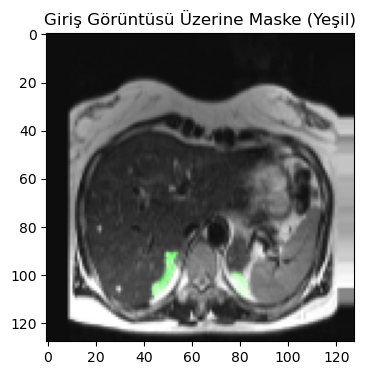

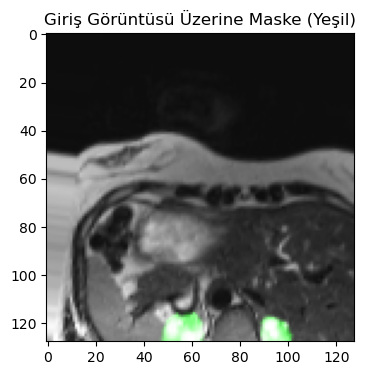

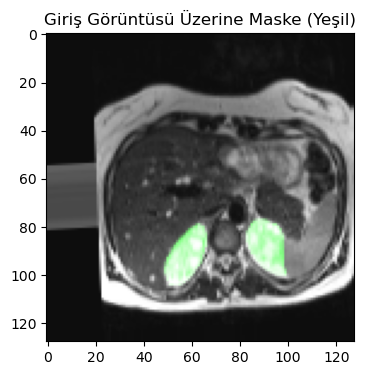

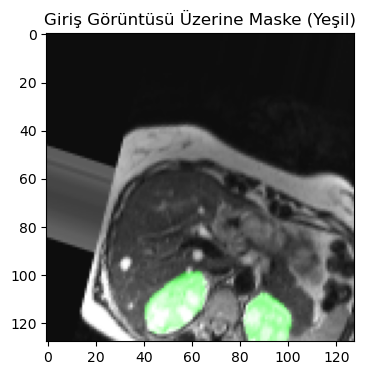

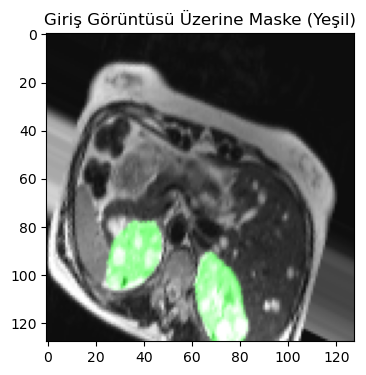

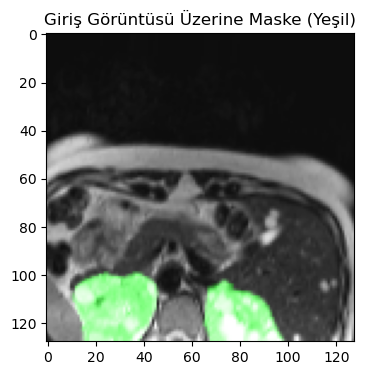

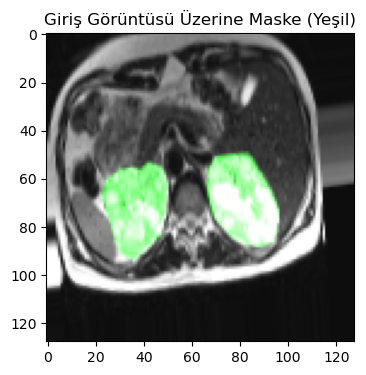

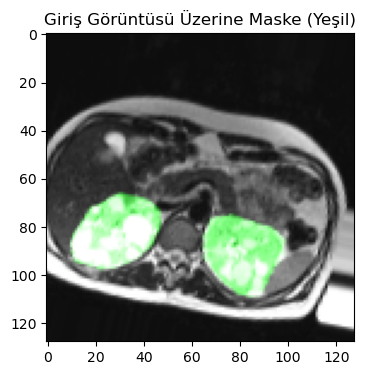

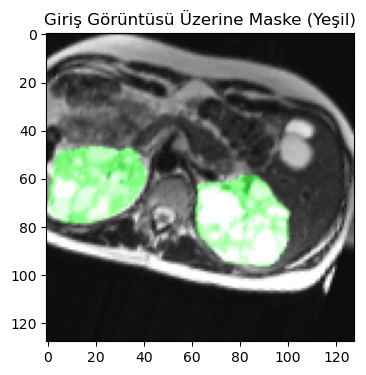

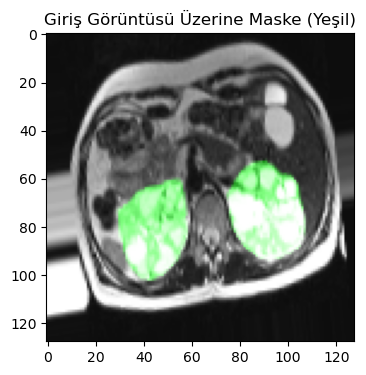

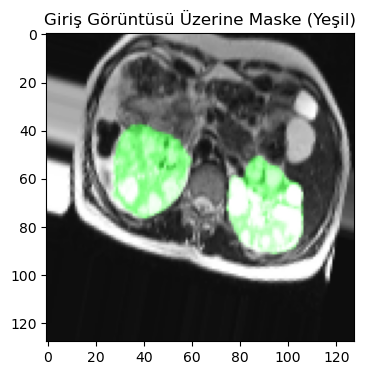

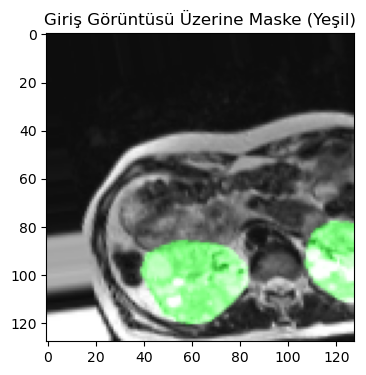

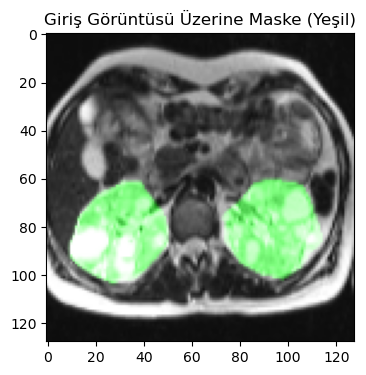

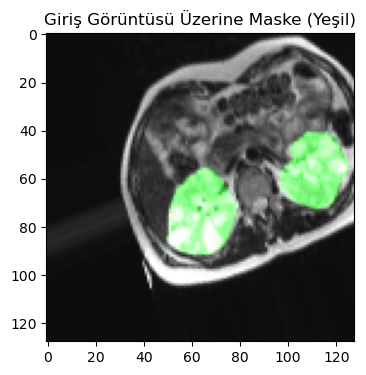

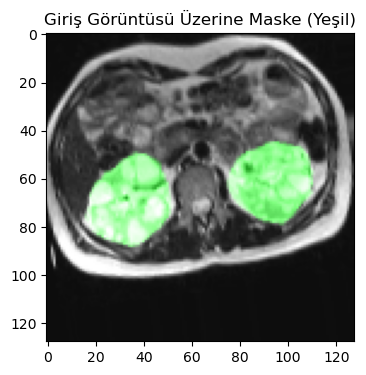

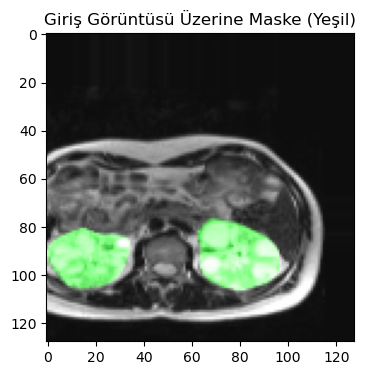

In [7]:
# İlk 16 artırılmış görüntü ve maskeleri alın
sample_images = augmented_train_data[:16]
sample_masks = augmented_train_mask[:16]

# Her bir örneği görselleştirme
for i in range(16):
    input_image = (sample_images[i] * 255).astype(np.uint8)  # Giriş görüntüsünü 0-255 aralığına geri getir
    real_mask = (sample_masks[i] * 255).astype(np.uint8).reshape(new_width, new_height)

    # Renkli maskeyi oluştur
    colored_mask = cv2.cvtColor(real_mask, cv2.COLOR_GRAY2RGB)
    colored_mask[:,:,0] = 0  # Mavi kanalı sıfır yap
    colored_mask[:,:,2] = 0  # Kırmızı kanalı sıfır yap

    # Giriş görüntüsü ve üstüne maskenin eklenmesi
    overlay = cv2.addWeighted(input_image, 1, colored_mask, 0.5, 0)

    # Görselleştirme
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 1, 1)
    plt.imshow(overlay)
    plt.title('Giriş Görüntüsü Üzerine Maske (Yeşil)')

    plt.show()


In [7]:
# Orijinal ve artırılmış verileri birleştirme
combined_train_data = np.concatenate((resized_train_data, augmented_train_data), axis=0)
combined_train_mask = np.concatenate((resized_train_mask, augmented_train_mask), axis=0)

# Veri birleştirme sonrası boyutları kontrol et
print("Birleştirilmiş eğitim verilerinin boyutu:", combined_train_data.shape)
print("Birleştirilmiş eğitim maskelerinin boyutu:", combined_train_mask.shape)

Birleştirilmiş eğitim verilerinin boyutu: (3888, 128, 128, 3)
Birleştirilmiş eğitim maskelerinin boyutu: (3888, 128, 128, 1)


# Half-UNet Model

In [8]:
img_height = 128
img_width = 128
img_channel = 3

In [9]:
# code for Half-UNet architecture based on the research paper
def ghost_module(inputs):
    conv1 = Conv2D(32, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    batch1 = BatchNormalization()(conv1)
    act1 = Activation('relu')(batch1)
    conv2 = SeparableConv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(act1)
    return concatenate([act1, conv2], axis = 3)

def model(input_shape = (128, 128, 3)):

    inputs = Input(shape=input_shape, name="image")
    x1 = ghost_module(ghost_module(inputs))
    pool1 = MaxPooling2D(pool_size=(2, 2))(x1)
    x2 = ghost_module(ghost_module(pool1))
    pool2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x3 = ghost_module(ghost_module(pool2))
    pool3 = MaxPooling2D(pool_size=(2, 2))(x3)
    x4 = ghost_module(ghost_module(pool3))
    pool4 = MaxPooling2D(pool_size=(2, 2))(x4)
    x5 = ghost_module(ghost_module(pool4))

    up5 = UpSampling2D(size = (input_shape[0] // x5.shape[1], input_shape[1] // x5.shape[2]))(x5)
    up4 = UpSampling2D(size = (input_shape[0] // x4.shape[1], input_shape[1] // x4.shape[2]))(x4)
    up3 = UpSampling2D(size = (input_shape[0] // x3.shape[1], input_shape[1] // x3.shape[2]))(x3)
    up2 = UpSampling2D(size = (input_shape[0] // x2.shape[1], input_shape[1] // x2.shape[2]))(x2)

    upScaled = Add()([x1, up2, up3, up4, up5])
    all_conv = ghost_module(ghost_module(upScaled))
    final_conv = Conv2D(1, 1, activation = 'sigmoid')(all_conv)

    # final_conv = Conv2D(2, (1, 1), activation = 'softmax')(all_conv)
    half_unet_model = tf.keras.Model(inputs, final_conv, name="Half-UNet")
    return half_unet_model

In [10]:
from tensorflow.keras.layers import Activation, SeparableConv2D, UpSampling2D, Add
half_unet_model = model((128, 128, 3))
half_unet_model.summary()

Model: "Half-UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                         

                                                                                                  
 activation_5 (Activation)      (None, 32, 32, 32)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 separable_conv2d_5 (SeparableC  (None, 32, 32, 32)  1344        ['activation_5[0][0]']           
 onv2D)                                                                                           
                                                                                                  
 concatenate_5 (Concatenate)    (None, 32, 32, 64)   0           ['activation_5[0][0]',           
                                                                  'separable_conv2d_5[0][0]']     
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 64)  0           ['concatenate_5[0][0]']          
          

 conv2d_10 (Conv2D)             (None, 128, 128, 32  18464       ['add[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_10 (BatchN  (None, 128, 128, 32  128        ['conv2d_10[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_10 (Activation)     (None, 128, 128, 32  0           ['batch_normalization_10[0][0]'] 
                                )                                                                 
                                                                                                  
 separable_conv2d_10 (Separable  (None, 128, 128, 32  1344       ['activation_10[0][0]']          
 Conv2D)  

# Metrics

In [11]:
def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def F1(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=(1, 2))  # 128x128 piksel boyutunda toplama yap
    precision = (intersection + smooth) / (K.sum(y_pred, axis=(1, 2)) + smooth)
    recall = (intersection + smooth) / (K.sum(y_true, axis=(1, 2)) + smooth)
    f1 = 2 * (precision * recall) / (precision + recall)
    return K.mean(f1)

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def dice_coef(y_true, y_pred, smooth = 0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred)
    return 1 - ((2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth))

# k-fold cross validation

In [13]:
from sklearn.model_selection import KFold

# K-Fold Cross Validation için KFold nesnesini oluşturun
kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_train_loss, all_val_loss, all_train_acc, all_val_acc = [], [], [], []

fold = 0

for train_index, test_index in kf.split(resized_train_data, resized_train_mask):
    fold += 1
    print(f"Fold {fold}:")

    # Eğitim ve test setlerini oluşturun
    X_train_fold, X_test_fold = resized_train_data[train_index], resized_train_data[test_index]
    y_train_fold, y_test_fold = resized_train_mask[train_index], resized_train_mask[test_index]

    # Yeni bir model oluşturun (her fold için yeni bir model)
    half_unet_model = model((img_height, img_width, 3))

    # Modeli derle
    half_unet_model.compile(optimizer='adam', 
                    loss='binary_crossentropy', 
                    metrics=['accuracy', F1, recall, precision, dice_coef, iou])

    # Modeli eğitin
    history = half_unet_model.fit(X_train_fold, 
                              y_train_fold, 
                              epochs=10, 
                              batch_size=32, 
                              verbose=1)

    # Modeli test edin
    test_results = half_unet_model.evaluate(X_test_fold, y_test_fold, batch_size=32)

    # Eğitim ve validation loss/accuracy değerlerini kaydedin
    all_train_loss.append(history.history['loss'])
    all_train_acc.append(history.history['accuracy'])
    all_val_loss.append(test_results[0])  # test_results içinde loss değeri 0. indexte
    all_val_acc.append(test_results[1])   # test_results içinde accuracy değeri 1. indexte


Fold 1:
Epoch 1/10
43/43 [==============================] - 139s 3s/step - loss: 0.2790 - accuracy: 0.9446 - F1: 0.2707 - recall: 0.7654 - precision: 0.6575 - dice_coef: 0.2962 - iou: 0.1671
Epoch 2/10
43/43 [==============================] - 133s 3s/step - loss: 0.0668 - accuracy: 0.9810 - F1: 0.5528 - recall: 0.8057 - precision: 0.8404 - dice_coef: 0.6182 - iou: 0.4068
Epoch 3/10
43/43 [==============================] - 131s 3s/step - loss: 0.0394 - accuracy: 0.9837 - F1: 0.6909 - recall: 0.8450 - precision: 0.8585 - dice_coef: 0.7635 - iou: 0.5547
Epoch 4/10
43/43 [==============================] - 132s 3s/step - loss: 0.0321 - accuracy: 0.9858 - F1: 0.7386 - recall: 0.8656 - precision: 0.8766 - dice_coef: 0.8070 - iou: 0.6121
Epoch 5/10
43/43 [==============================] - 135s 3s/step - loss: 0.0289 - accuracy: 0.9868 - F1: 0.7652 - recall: 0.8811 - precision: 0.8826 - dice_coef: 0.8306 - iou: 0.6456
Epoch 6/10
43/43 [==============================] - 134s 3s/step - loss: 0.02

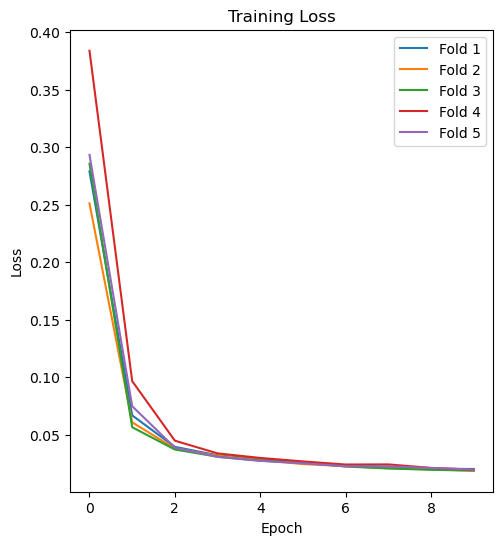

In [14]:
# Eğitim ve validation loss grafiği çizin
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i in range(5):
    plt.plot(all_train_loss[i], label=f'Fold {i + 1}')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Grid Search

In [10]:
from sklearn.model_selection import ParameterGrid

In [11]:
# Define the hyperparameters grid
param_grid = {
    'learning_rate': [1e-3, 5e-3, 1e-4],
    'batch_size': [32,64],                 #, 32, 64],
    'epochs': [40, 80]
}
# Convert the grid to a list of dictionaries
param_combinations = list(ParameterGrid(param_grid))


In [12]:
def build_compile_half_unet(input_shape, learning_rate):
    half_unet_model = model(input_shape)
    half_unet_model.compile(optimizer=Adam(learning_rate),
                            loss='binary_crossentropy',
                            metrics=['accuracy', F1, recall, precision, dice_coef, iou])
    return half_unet_model


In [13]:
best_model = None
best_dice_coefficient = 0

In [14]:
input_shape = (img_height, img_width, img_channel)
for params in param_combinations:
    print(f"\nTraining with hyperparameters: {params}")

    # Build and compile model
    half_unet_model = build_compile_half_unet(input_shape, params['learning_rate'])

    # Train the model
    history = half_unet_model.fit(
        resized_train_data,
        resized_train_mask,
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        validation_data=(resized_validation_data, resized_validation_mask),
        verbose=2
    )
    
    # Evaluate the model on validation data
    eval_metrics = half_unet_model.evaluate(resized_validation_data, resized_validation_mask, verbose=0)
    
    # Assuming 'dice_coef' is the metric at index 5
    dice_coefficient = eval_metrics[5]
    print(f"Validation dice coefficient: {dice_coefficient}")

    if dice_coefficient > best_dice_coefficient:
        best_dice_coefficient = dice_coefficient
        best_model = half_unet_model

print("\nBest Hyperparameters:")
#print(best_model.get_config())


Training with hyperparameters: {'batch_size': 32, 'epochs': 40, 'learning_rate': 0.001}
Epoch 1/40
54/54 - 246s - loss: 0.2456 - accuracy: 0.9466 - F1: 0.3064 - recall: 0.7893 - precision: 0.6551 - dice_coef: 0.3357 - iou: 0.1953 - val_loss: 0.3043 - val_accuracy: 0.9202 - val_F1: 0.0695 - val_recall: 0.6640 - val_precision: 0.1180 - val_dice_coef: 0.0712 - val_iou: 0.0371 - 246s/epoch - 5s/step
Epoch 2/40
54/54 - 235s - loss: 0.0511 - accuracy: 0.9833 - F1: 0.6234 - recall: 0.8306 - precision: 0.8638 - dice_coef: 0.6971 - iou: 0.4820 - val_loss: 0.1791 - val_accuracy: 0.9187 - val_F1: 0.1560 - val_recall: 0.8731 - val_precision: 0.1395 - val_dice_coef: 0.1619 - val_iou: 0.0896 - 235s/epoch - 4s/step
Epoch 3/40
54/54 - 239s - loss: 0.0329 - accuracy: 0.9859 - F1: 0.7312 - recall: 0.8684 - precision: 0.8794 - dice_coef: 0.8038 - iou: 0.6047 - val_loss: 0.0523 - val_accuracy: 0.9820 - val_F1: 0.2798 - val_recall: 0.6178 - val_precision: 0.4264 - val_dice_coef: 0.3071 - val_iou: 0.1774 -

Epoch 27/40
54/54 - 156s - loss: 0.0117 - accuracy: 0.9935 - F1: 0.9038 - recall: 0.9469 - precision: 0.9476 - dice_coef: 0.9315 - iou: 0.8326 - val_loss: 0.0385 - val_accuracy: 0.9873 - val_F1: 0.5886 - val_recall: 0.8761 - val_precision: 0.5515 - val_dice_coef: 0.6488 - val_iou: 0.4541 - 156s/epoch - 3s/step
Epoch 28/40
54/54 - 162s - loss: 0.0112 - accuracy: 0.9937 - F1: 0.9070 - recall: 0.9480 - precision: 0.9503 - dice_coef: 0.9343 - iou: 0.8381 - val_loss: 0.0305 - val_accuracy: 0.9894 - val_F1: 0.5935 - val_recall: 0.8071 - val_precision: 0.6238 - val_dice_coef: 0.6732 - val_iou: 0.4606 - 162s/epoch - 3s/step
Epoch 29/40
54/54 - 155s - loss: 0.0114 - accuracy: 0.9936 - F1: 0.9069 - recall: 0.9478 - precision: 0.9483 - dice_coef: 0.9336 - iou: 0.8374 - val_loss: 0.0302 - val_accuracy: 0.9899 - val_F1: 0.6021 - val_recall: 0.7750 - val_precision: 0.6535 - val_dice_coef: 0.6809 - val_iou: 0.4726 - 155s/epoch - 3s/step
Epoch 30/40
54/54 - 155s - loss: 0.0113 - accuracy: 0.9937 - F1:

Epoch 13/40
54/54 - 154s - loss: 0.0150 - accuracy: 0.9922 - F1: 0.8765 - recall: 0.9329 - precision: 0.9353 - dice_coef: 0.9134 - iou: 0.7924 - val_loss: 0.0279 - val_accuracy: 0.9898 - val_F1: 0.5716 - val_recall: 0.7391 - val_precision: 0.6553 - val_dice_coef: 0.6547 - val_iou: 0.4387 - 154s/epoch - 3s/step
Epoch 14/40
54/54 - 153s - loss: 0.0148 - accuracy: 0.9923 - F1: 0.8772 - recall: 0.9330 - precision: 0.9370 - dice_coef: 0.9144 - iou: 0.7947 - val_loss: 0.0219 - val_accuracy: 0.9913 - val_F1: 0.5857 - val_recall: 0.7532 - val_precision: 0.7213 - val_dice_coef: 0.6785 - val_iou: 0.4511 - 153s/epoch - 3s/step
Epoch 15/40
54/54 - 156s - loss: 0.0144 - accuracy: 0.9925 - F1: 0.8827 - recall: 0.9351 - precision: 0.9391 - dice_coef: 0.9171 - iou: 0.8014 - val_loss: 0.0231 - val_accuracy: 0.9908 - val_F1: 0.6177 - val_recall: 0.8142 - val_precision: 0.6715 - val_dice_coef: 0.6935 - val_iou: 0.4828 - 156s/epoch - 3s/step
Epoch 16/40
54/54 - 157s - loss: 0.0142 - accuracy: 0.9925 - F1:

Epoch 40/40
54/54 - 158s - loss: 0.0091 - accuracy: 0.9945 - F1: 0.9280 - recall: 0.9561 - precision: 0.9584 - dice_coef: 0.9468 - iou: 0.8702 - val_loss: 0.0355 - val_accuracy: 0.9900 - val_F1: 0.6412 - val_recall: 0.8342 - val_precision: 0.6399 - val_dice_coef: 0.7027 - val_iou: 0.5137 - 158s/epoch - 3s/step
Validation dice coefficient: 0.7027367949485779

Training with hyperparameters: {'batch_size': 32, 'epochs': 40, 'learning_rate': 0.0001}
Epoch 1/40
54/54 - 171s - loss: 0.3328 - accuracy: 0.9390 - F1: 0.1639 - recall: 0.5111 - precision: 0.4139 - dice_coef: 0.1743 - iou: 0.0930 - val_loss: 0.5148 - val_accuracy: 0.9454 - val_F1: 0.0339 - val_recall: 0.4496 - val_precision: 0.1422 - val_dice_coef: 0.0345 - val_iou: 0.0175 - 171s/epoch - 3s/step
Epoch 2/40
54/54 - 173s - loss: 0.2085 - accuracy: 0.9692 - F1: 0.2789 - recall: 0.7758 - precision: 0.6920 - dice_coef: 0.3022 - iou: 0.1698 - val_loss: 0.3782 - val_accuracy: 0.9454 - val_F1: 0.0449 - val_recall: 0.4746 - val_precision: 

Epoch 26/40
54/54 - 198s - loss: 0.0219 - accuracy: 0.9900 - F1: 0.8127 - recall: 0.9128 - precision: 0.9141 - dice_coef: 0.8690 - iou: 0.7052 - val_loss: 0.0296 - val_accuracy: 0.9881 - val_F1: 0.4945 - val_recall: 0.7224 - val_precision: 0.6053 - val_dice_coef: 0.5742 - val_iou: 0.3598 - 198s/epoch - 4s/step
Epoch 27/40
54/54 - 240s - loss: 0.0215 - accuracy: 0.9901 - F1: 0.8164 - recall: 0.9134 - precision: 0.9157 - dice_coef: 0.8717 - iou: 0.7104 - val_loss: 0.0291 - val_accuracy: 0.9881 - val_F1: 0.4997 - val_recall: 0.7399 - val_precision: 0.5925 - val_dice_coef: 0.5785 - val_iou: 0.3654 - 240s/epoch - 4s/step
Epoch 28/40
54/54 - 245s - loss: 0.0209 - accuracy: 0.9903 - F1: 0.8212 - recall: 0.9162 - precision: 0.9163 - dice_coef: 0.8755 - iou: 0.7163 - val_loss: 0.0279 - val_accuracy: 0.9890 - val_F1: 0.5000 - val_recall: 0.6925 - val_precision: 0.6372 - val_dice_coef: 0.5872 - val_iou: 0.3680 - 245s/epoch - 5s/step
Epoch 29/40
54/54 - 241s - loss: 0.0209 - accuracy: 0.9903 - F1:

Epoch 12/80
54/54 - 153s - loss: 0.0175 - accuracy: 0.9912 - F1: 0.8520 - recall: 0.9226 - precision: 0.9273 - dice_coef: 0.8985 - iou: 0.7590 - val_loss: 0.0273 - val_accuracy: 0.9893 - val_F1: 0.5517 - val_recall: 0.7526 - val_precision: 0.6421 - val_dice_coef: 0.6342 - val_iou: 0.4194 - 153s/epoch - 3s/step
Epoch 13/80
54/54 - 153s - loss: 0.0172 - accuracy: 0.9913 - F1: 0.8560 - recall: 0.9259 - precision: 0.9254 - dice_coef: 0.9006 - iou: 0.7644 - val_loss: 0.0283 - val_accuracy: 0.9890 - val_F1: 0.5398 - val_recall: 0.7608 - val_precision: 0.6255 - val_dice_coef: 0.6181 - val_iou: 0.4048 - 153s/epoch - 3s/step
Epoch 14/80
54/54 - 156s - loss: 0.0167 - accuracy: 0.9915 - F1: 0.8578 - recall: 0.9254 - precision: 0.9301 - dice_coef: 0.9024 - iou: 0.7673 - val_loss: 0.0260 - val_accuracy: 0.9901 - val_F1: 0.5328 - val_recall: 0.6488 - val_precision: 0.7047 - val_dice_coef: 0.6249 - val_iou: 0.4022 - 156s/epoch - 3s/step
Epoch 15/80
54/54 - 152s - loss: 0.0165 - accuracy: 0.9916 - F1:

Epoch 39/80
54/54 - 152s - loss: 0.0102 - accuracy: 0.9941 - F1: 0.9170 - recall: 0.9517 - precision: 0.9543 - dice_coef: 0.9402 - iou: 0.8528 - val_loss: 0.0328 - val_accuracy: 0.9894 - val_F1: 0.6030 - val_recall: 0.7845 - val_precision: 0.6297 - val_dice_coef: 0.6660 - val_iou: 0.4712 - 152s/epoch - 3s/step
Epoch 40/80
54/54 - 154s - loss: 0.0099 - accuracy: 0.9942 - F1: 0.9195 - recall: 0.9544 - precision: 0.9532 - dice_coef: 0.9417 - iou: 0.8567 - val_loss: 0.0363 - val_accuracy: 0.9888 - val_F1: 0.5916 - val_recall: 0.7999 - val_precision: 0.6071 - val_dice_coef: 0.6646 - val_iou: 0.4615 - 154s/epoch - 3s/step
Epoch 41/80
54/54 - 155s - loss: 0.0096 - accuracy: 0.9943 - F1: 0.9210 - recall: 0.9549 - precision: 0.9555 - dice_coef: 0.9435 - iou: 0.8595 - val_loss: 0.0415 - val_accuracy: 0.9871 - val_F1: 0.5883 - val_recall: 0.8577 - val_precision: 0.5466 - val_dice_coef: 0.6433 - val_iou: 0.4544 - 155s/epoch - 3s/step
Epoch 42/80
54/54 - 153s - loss: 0.0095 - accuracy: 0.9944 - F1:

Epoch 66/80
54/54 - 216s - loss: 0.0080 - accuracy: 0.9950 - F1: 0.9371 - recall: 0.9614 - precision: 0.9623 - dice_coef: 0.9534 - iou: 0.8850 - val_loss: 0.0513 - val_accuracy: 0.9848 - val_F1: 0.5530 - val_recall: 0.8856 - val_precision: 0.4899 - val_dice_coef: 0.6091 - val_iou: 0.4202 - 216s/epoch - 4s/step
Epoch 67/80
54/54 - 243s - loss: 0.0080 - accuracy: 0.9950 - F1: 0.9361 - recall: 0.9618 - precision: 0.9612 - dice_coef: 0.9529 - iou: 0.8835 - val_loss: 0.0394 - val_accuracy: 0.9891 - val_F1: 0.6103 - val_recall: 0.8320 - val_precision: 0.6043 - val_dice_coef: 0.6824 - val_iou: 0.4819 - 243s/epoch - 4s/step
Epoch 68/80
54/54 - 256s - loss: 0.0083 - accuracy: 0.9949 - F1: 0.9339 - recall: 0.9602 - precision: 0.9612 - dice_coef: 0.9517 - iou: 0.8803 - val_loss: 0.0424 - val_accuracy: 0.9882 - val_F1: 0.5979 - val_recall: 0.8296 - val_precision: 0.5823 - val_dice_coef: 0.6675 - val_iou: 0.4686 - 256s/epoch - 5s/step
Epoch 69/80
54/54 - 210s - loss: 0.0077 - accuracy: 0.9951 - F1:

Epoch 12/80
54/54 - 154s - loss: 0.0150 - accuracy: 0.9922 - F1: 0.8752 - recall: 0.9329 - precision: 0.9354 - dice_coef: 0.9132 - iou: 0.7915 - val_loss: 0.0212 - val_accuracy: 0.9918 - val_F1: 0.6075 - val_recall: 0.7060 - val_precision: 0.7723 - val_dice_coef: 0.6972 - val_iou: 0.4782 - 154s/epoch - 3s/step
Epoch 13/80
54/54 - 154s - loss: 0.0149 - accuracy: 0.9922 - F1: 0.8775 - recall: 0.9309 - precision: 0.9381 - dice_coef: 0.9139 - iou: 0.7944 - val_loss: 0.0673 - val_accuracy: 0.9774 - val_F1: 0.4758 - val_recall: 0.9453 - val_precision: 0.3994 - val_dice_coef: 0.5182 - val_iou: 0.3431 - 154s/epoch - 3s/step
Epoch 14/80
54/54 - 157s - loss: 0.0144 - accuracy: 0.9924 - F1: 0.8793 - recall: 0.9362 - precision: 0.9363 - dice_coef: 0.9165 - iou: 0.7976 - val_loss: 0.0224 - val_accuracy: 0.9912 - val_F1: 0.6178 - val_recall: 0.7497 - val_precision: 0.7232 - val_dice_coef: 0.6899 - val_iou: 0.4829 - 157s/epoch - 3s/step
Epoch 15/80
54/54 - 164s - loss: 0.0152 - accuracy: 0.9921 - F1:

Epoch 39/80
54/54 - 153s - loss: 0.0083 - accuracy: 0.9949 - F1: 0.9350 - recall: 0.9584 - precision: 0.9621 - dice_coef: 0.9513 - iou: 0.8813 - val_loss: 0.0314 - val_accuracy: 0.9908 - val_F1: 0.6571 - val_recall: 0.8194 - val_precision: 0.6768 - val_dice_coef: 0.7187 - val_iou: 0.5308 - 153s/epoch - 3s/step
Epoch 40/80
54/54 - 155s - loss: 0.0082 - accuracy: 0.9949 - F1: 0.9347 - recall: 0.9596 - precision: 0.9610 - dice_coef: 0.9516 - iou: 0.8811 - val_loss: 0.0319 - val_accuracy: 0.9909 - val_F1: 0.6693 - val_recall: 0.8440 - val_precision: 0.6657 - val_dice_coef: 0.7263 - val_iou: 0.5415 - 155s/epoch - 3s/step
Epoch 41/80
54/54 - 153s - loss: 0.0081 - accuracy: 0.9949 - F1: 0.9359 - recall: 0.9596 - precision: 0.9617 - dice_coef: 0.9521 - iou: 0.8830 - val_loss: 0.0353 - val_accuracy: 0.9897 - val_F1: 0.6175 - val_recall: 0.8301 - val_precision: 0.6286 - val_dice_coef: 0.6965 - val_iou: 0.4896 - 153s/epoch - 3s/step
Epoch 42/80
54/54 - 156s - loss: 0.0082 - accuracy: 0.9949 - F1:

Epoch 66/80
54/54 - 154s - loss: 0.0067 - accuracy: 0.9955 - F1: 0.9479 - recall: 0.9657 - precision: 0.9672 - dice_coef: 0.9603 - iou: 0.9030 - val_loss: 0.0395 - val_accuracy: 0.9911 - val_F1: 0.6588 - val_recall: 0.7915 - val_precision: 0.6947 - val_dice_coef: 0.7258 - val_iou: 0.5372 - 154s/epoch - 3s/step
Epoch 67/80
54/54 - 154s - loss: 0.0066 - accuracy: 0.9955 - F1: 0.9485 - recall: 0.9662 - precision: 0.9675 - dice_coef: 0.9609 - iou: 0.9042 - val_loss: 0.0311 - val_accuracy: 0.9924 - val_F1: 0.6795 - val_recall: 0.7641 - val_precision: 0.7665 - val_dice_coef: 0.7517 - val_iou: 0.5590 - 154s/epoch - 3s/step
Epoch 68/80
54/54 - 153s - loss: 0.0067 - accuracy: 0.9955 - F1: 0.9479 - recall: 0.9661 - precision: 0.9671 - dice_coef: 0.9605 - iou: 0.9031 - val_loss: 0.0494 - val_accuracy: 0.9890 - val_F1: 0.6385 - val_recall: 0.8630 - val_precision: 0.6025 - val_dice_coef: 0.6964 - val_iou: 0.5127 - 153s/epoch - 3s/step
Epoch 69/80
54/54 - 156s - loss: 0.0065 - accuracy: 0.9956 - F1:

Epoch 12/80
54/54 - 156s - loss: 0.0425 - accuracy: 0.9871 - F1: 0.6540 - recall: 0.8786 - precision: 0.8903 - dice_coef: 0.7318 - iou: 0.5115 - val_loss: 0.0465 - val_accuracy: 0.9857 - val_F1: 0.3203 - val_recall: 0.7109 - val_precision: 0.5358 - val_dice_coef: 0.3774 - val_iou: 0.2067 - 156s/epoch - 3s/step
Epoch 13/80
54/54 - 154s - loss: 0.0392 - accuracy: 0.9873 - F1: 0.6753 - recall: 0.8797 - precision: 0.8930 - dice_coef: 0.7528 - iou: 0.5360 - val_loss: 0.0521 - val_accuracy: 0.9820 - val_F1: 0.3375 - val_recall: 0.8061 - val_precision: 0.4500 - val_dice_coef: 0.3904 - val_iou: 0.2195 - 154s/epoch - 3s/step
Epoch 14/80
54/54 - 154s - loss: 0.0372 - accuracy: 0.9870 - F1: 0.6923 - recall: 0.8796 - precision: 0.8917 - dice_coef: 0.7679 - iou: 0.5556 - val_loss: 0.0421 - val_accuracy: 0.9854 - val_F1: 0.3598 - val_recall: 0.7149 - val_precision: 0.5395 - val_dice_coef: 0.4247 - val_iou: 0.2387 - 154s/epoch - 3s/step
Epoch 15/80
54/54 - 155s - loss: 0.0337 - accuracy: 0.9877 - F1:

Epoch 39/80
54/54 - 157s - loss: 0.0174 - accuracy: 0.9915 - F1: 0.8512 - recall: 0.9296 - precision: 0.9252 - dice_coef: 0.8967 - iou: 0.7568 - val_loss: 0.0319 - val_accuracy: 0.9877 - val_F1: 0.5078 - val_recall: 0.6885 - val_precision: 0.5963 - val_dice_coef: 0.5866 - val_iou: 0.3746 - 157s/epoch - 3s/step
Epoch 40/80
54/54 - 154s - loss: 0.0172 - accuracy: 0.9915 - F1: 0.8533 - recall: 0.9285 - precision: 0.9278 - dice_coef: 0.8979 - iou: 0.7594 - val_loss: 0.0354 - val_accuracy: 0.9867 - val_F1: 0.5031 - val_recall: 0.7060 - val_precision: 0.5594 - val_dice_coef: 0.5767 - val_iou: 0.3696 - 154s/epoch - 3s/step
Epoch 41/80
54/54 - 154s - loss: 0.0167 - accuracy: 0.9918 - F1: 0.8573 - recall: 0.9314 - precision: 0.9290 - dice_coef: 0.9008 - iou: 0.7650 - val_loss: 0.0336 - val_accuracy: 0.9872 - val_F1: 0.5011 - val_recall: 0.6781 - val_precision: 0.5765 - val_dice_coef: 0.5786 - val_iou: 0.3686 - 154s/epoch - 3s/step
Epoch 42/80
54/54 - 153s - loss: 0.0164 - accuracy: 0.9919 - F1:

Epoch 66/80
54/54 - 155s - loss: 0.0140 - accuracy: 0.9927 - F1: 0.8831 - recall: 0.9396 - precision: 0.9390 - dice_coef: 0.9185 - iou: 0.8023 - val_loss: 0.0398 - val_accuracy: 0.9860 - val_F1: 0.5307 - val_recall: 0.7565 - val_precision: 0.5345 - val_dice_coef: 0.5934 - val_iou: 0.3960 - 155s/epoch - 3s/step
Epoch 67/80
54/54 - 155s - loss: 0.0134 - accuracy: 0.9929 - F1: 0.8877 - recall: 0.9444 - precision: 0.9381 - dice_coef: 0.9209 - iou: 0.8086 - val_loss: 0.0334 - val_accuracy: 0.9890 - val_F1: 0.5258 - val_recall: 0.6204 - val_precision: 0.6477 - val_dice_coef: 0.6052 - val_iou: 0.3942 - 155s/epoch - 3s/step
Epoch 68/80
54/54 - 155s - loss: 0.0134 - accuracy: 0.9929 - F1: 0.8867 - recall: 0.9416 - precision: 0.9411 - dice_coef: 0.9213 - iou: 0.8074 - val_loss: 0.0366 - val_accuracy: 0.9875 - val_F1: 0.5278 - val_recall: 0.6825 - val_precision: 0.5799 - val_dice_coef: 0.5971 - val_iou: 0.3958 - 155s/epoch - 3s/step
Epoch 69/80
54/54 - 155s - loss: 0.0132 - accuracy: 0.9930 - F1:

Epoch 12/40
27/27 - 154s - loss: 0.0189 - accuracy: 0.9908 - F1: 0.8375 - recall: 0.9170 - precision: 0.9240 - dice_coef: 0.8896 - iou: 0.7394 - val_loss: 0.0332 - val_accuracy: 0.9879 - val_F1: 0.4008 - val_recall: 0.4594 - val_precision: 0.6628 - val_dice_coef: 0.4898 - val_iou: 0.2840 - 154s/epoch - 6s/step
Epoch 13/40
27/27 - 154s - loss: 0.0185 - accuracy: 0.9909 - F1: 0.8434 - recall: 0.9219 - precision: 0.9218 - dice_coef: 0.8933 - iou: 0.7478 - val_loss: 0.0268 - val_accuracy: 0.9897 - val_F1: 0.4763 - val_recall: 0.5774 - val_precision: 0.7062 - val_dice_coef: 0.5757 - val_iou: 0.3493 - 154s/epoch - 6s/step
Epoch 14/40
27/27 - 154s - loss: 0.0178 - accuracy: 0.9912 - F1: 0.8479 - recall: 0.9235 - precision: 0.9255 - dice_coef: 0.8960 - iou: 0.7532 - val_loss: 0.0243 - val_accuracy: 0.9901 - val_F1: 0.5235 - val_recall: 0.6819 - val_precision: 0.6780 - val_dice_coef: 0.6145 - val_iou: 0.3902 - 154s/epoch - 6s/step
Epoch 15/40
27/27 - 153s - loss: 0.0172 - accuracy: 0.9914 - F1:

Epoch 39/40
27/27 - 152s - loss: 0.0115 - accuracy: 0.9936 - F1: 0.9041 - recall: 0.9475 - precision: 0.9489 - dice_coef: 0.9336 - iou: 0.8340 - val_loss: 0.0304 - val_accuracy: 0.9896 - val_F1: 0.5929 - val_recall: 0.7880 - val_precision: 0.6305 - val_dice_coef: 0.6761 - val_iou: 0.4601 - 152s/epoch - 6s/step
Epoch 40/40
27/27 - 153s - loss: 0.0106 - accuracy: 0.9940 - F1: 0.9113 - recall: 0.9499 - precision: 0.9539 - dice_coef: 0.9381 - iou: 0.8449 - val_loss: 0.0474 - val_accuracy: 0.9842 - val_F1: 0.5510 - val_recall: 0.9052 - val_precision: 0.4903 - val_dice_coef: 0.6134 - val_iou: 0.4138 - 153s/epoch - 6s/step
Validation dice coefficient: 0.604943037033081

Training with hyperparameters: {'batch_size': 64, 'epochs': 40, 'learning_rate': 0.005}
Epoch 1/40
27/27 - 162s - loss: 0.1571 - accuracy: 0.9456 - F1: 0.4321 - recall: 0.6796 - precision: 0.6775 - dice_coef: 0.4723 - iou: 0.3076 - val_loss: 1.0114 - val_accuracy: 0.9843 - val_F1: 0.0114 - val_recall: 0.0000e+00 - val_precisio

Epoch 25/40
27/27 - 151s - loss: 0.0116 - accuracy: 0.9935 - F1: 0.9058 - recall: 0.9459 - precision: 0.9492 - dice_coef: 0.9329 - iou: 0.8357 - val_loss: 0.0275 - val_accuracy: 0.9908 - val_F1: 0.6210 - val_recall: 0.7751 - val_precision: 0.6862 - val_dice_coef: 0.6989 - val_iou: 0.4917 - 151s/epoch - 6s/step
Epoch 26/40
27/27 - 154s - loss: 0.0113 - accuracy: 0.9937 - F1: 0.9076 - recall: 0.9468 - precision: 0.9508 - dice_coef: 0.9344 - iou: 0.8386 - val_loss: 0.0266 - val_accuracy: 0.9916 - val_F1: 0.6318 - val_recall: 0.7464 - val_precision: 0.7344 - val_dice_coef: 0.7143 - val_iou: 0.5037 - 154s/epoch - 6s/step
Epoch 27/40
27/27 - 154s - loss: 0.0110 - accuracy: 0.9938 - F1: 0.9114 - recall: 0.9493 - precision: 0.9505 - dice_coef: 0.9365 - iou: 0.8439 - val_loss: 0.0293 - val_accuracy: 0.9912 - val_F1: 0.6176 - val_recall: 0.6958 - val_precision: 0.7471 - val_dice_coef: 0.6992 - val_iou: 0.4914 - 154s/epoch - 6s/step
Epoch 28/40
27/27 - 157s - loss: 0.0113 - accuracy: 0.9937 - F1:

Epoch 11/40
27/27 - 160s - loss: 0.1401 - accuracy: 0.9830 - F1: 0.3704 - recall: 0.8236 - precision: 0.8652 - dice_coef: 0.4167 - iou: 0.2410 - val_loss: 0.1883 - val_accuracy: 0.9750 - val_F1: 0.1013 - val_recall: 0.6577 - val_precision: 0.3290 - val_dice_coef: 0.1072 - val_iou: 0.0552 - 160s/epoch - 6s/step
Epoch 12/40
27/27 - 153s - loss: 0.1277 - accuracy: 0.9834 - F1: 0.3890 - recall: 0.8226 - precision: 0.8736 - dice_coef: 0.4387 - iou: 0.2562 - val_loss: 0.2481 - val_accuracy: 0.9375 - val_F1: 0.1167 - val_recall: 0.8935 - val_precision: 0.1774 - val_dice_coef: 0.1229 - val_iou: 0.0644 - 153s/epoch - 6s/step
Epoch 13/40
27/27 - 153s - loss: 0.1154 - accuracy: 0.9841 - F1: 0.4118 - recall: 0.8286 - precision: 0.8793 - dice_coef: 0.4656 - iou: 0.2754 - val_loss: 0.2472 - val_accuracy: 0.9352 - val_F1: 0.1277 - val_recall: 0.9168 - val_precision: 0.1750 - val_dice_coef: 0.1346 - val_iou: 0.0711 - 153s/epoch - 6s/step
Epoch 14/40
27/27 - 154s - loss: 0.1041 - accuracy: 0.9844 - F1:

Epoch 38/40
27/27 - 156s - loss: 0.0263 - accuracy: 0.9897 - F1: 0.7663 - recall: 0.9019 - precision: 0.9174 - dice_coef: 0.8369 - iou: 0.6469 - val_loss: 0.0331 - val_accuracy: 0.9891 - val_F1: 0.4086 - val_recall: 0.6030 - val_precision: 0.6694 - val_dice_coef: 0.4929 - val_iou: 0.2824 - 156s/epoch - 6s/step
Epoch 39/40
27/27 - 154s - loss: 0.0257 - accuracy: 0.9898 - F1: 0.7705 - recall: 0.9013 - precision: 0.9201 - dice_coef: 0.8412 - iou: 0.6525 - val_loss: 0.0367 - val_accuracy: 0.9873 - val_F1: 0.4250 - val_recall: 0.6892 - val_precision: 0.5729 - val_dice_coef: 0.4997 - val_iou: 0.2954 - 154s/epoch - 6s/step
Epoch 40/40
27/27 - 155s - loss: 0.0254 - accuracy: 0.9898 - F1: 0.7751 - recall: 0.9044 - precision: 0.9170 - dice_coef: 0.8434 - iou: 0.6580 - val_loss: 0.0331 - val_accuracy: 0.9887 - val_F1: 0.4330 - val_recall: 0.6569 - val_precision: 0.6287 - val_dice_coef: 0.5139 - val_iou: 0.3031 - 155s/epoch - 6s/step
Validation dice coefficient: 0.508999228477478

Training with hy

Epoch 24/80
27/27 - 153s - loss: 0.0137 - accuracy: 0.9928 - F1: 0.8866 - recall: 0.9380 - precision: 0.9424 - dice_coef: 0.9207 - iou: 0.8073 - val_loss: 0.0516 - val_accuracy: 0.9810 - val_F1: 0.5088 - val_recall: 0.9142 - val_precision: 0.4386 - val_dice_coef: 0.5598 - val_iou: 0.3743 - 153s/epoch - 6s/step
Epoch 25/80
27/27 - 153s - loss: 0.0139 - accuracy: 0.9927 - F1: 0.8852 - recall: 0.9397 - precision: 0.9392 - dice_coef: 0.9200 - iou: 0.8053 - val_loss: 0.0250 - val_accuracy: 0.9901 - val_F1: 0.5821 - val_recall: 0.7691 - val_precision: 0.6535 - val_dice_coef: 0.6637 - val_iou: 0.4467 - 153s/epoch - 6s/step
Epoch 26/80
27/27 - 152s - loss: 0.0131 - accuracy: 0.9930 - F1: 0.8911 - recall: 0.9410 - precision: 0.9430 - dice_coef: 0.9234 - iou: 0.8137 - val_loss: 0.0500 - val_accuracy: 0.9814 - val_F1: 0.5123 - val_recall: 0.9000 - val_precision: 0.4440 - val_dice_coef: 0.5669 - val_iou: 0.3780 - 152s/epoch - 6s/step
Epoch 27/80
27/27 - 155s - loss: 0.0127 - accuracy: 0.9931 - F1:

Epoch 51/80
27/27 - 152s - loss: 0.0098 - accuracy: 0.9943 - F1: 0.9208 - recall: 0.9538 - precision: 0.9559 - dice_coef: 0.9432 - iou: 0.8591 - val_loss: 0.0291 - val_accuracy: 0.9910 - val_F1: 0.5655 - val_recall: 0.6057 - val_precision: 0.7799 - val_dice_coef: 0.6631 - val_iou: 0.4355 - 152s/epoch - 6s/step
Epoch 52/80
27/27 - 153s - loss: 0.0095 - accuracy: 0.9944 - F1: 0.9227 - recall: 0.9550 - precision: 0.9574 - dice_coef: 0.9444 - iou: 0.8620 - val_loss: 0.0454 - val_accuracy: 0.9858 - val_F1: 0.5729 - val_recall: 0.8713 - val_precision: 0.5205 - val_dice_coef: 0.6350 - val_iou: 0.4383 - 153s/epoch - 6s/step
Epoch 53/80
27/27 - 153s - loss: 0.0095 - accuracy: 0.9944 - F1: 0.9235 - recall: 0.9553 - precision: 0.9574 - dice_coef: 0.9450 - iou: 0.8633 - val_loss: 0.0328 - val_accuracy: 0.9890 - val_F1: 0.6038 - val_recall: 0.8229 - val_precision: 0.6050 - val_dice_coef: 0.6753 - val_iou: 0.4697 - 153s/epoch - 6s/step
Epoch 54/80
27/27 - 156s - loss: 0.0094 - accuracy: 0.9944 - F1:

Epoch 78/80
27/27 - 150s - loss: 0.0077 - accuracy: 0.9951 - F1: 0.9380 - recall: 0.9622 - precision: 0.9638 - dice_coef: 0.9547 - iou: 0.8867 - val_loss: 0.0351 - val_accuracy: 0.9900 - val_F1: 0.6204 - val_recall: 0.7799 - val_precision: 0.6512 - val_dice_coef: 0.6971 - val_iou: 0.4916 - 150s/epoch - 6s/step
Epoch 79/80
27/27 - 153s - loss: 0.0080 - accuracy: 0.9950 - F1: 0.9371 - recall: 0.9614 - precision: 0.9629 - dice_coef: 0.9538 - iou: 0.8851 - val_loss: 0.0332 - val_accuracy: 0.9898 - val_F1: 0.6217 - val_recall: 0.7925 - val_precision: 0.6398 - val_dice_coef: 0.6930 - val_iou: 0.4909 - 153s/epoch - 6s/step
Epoch 80/80
27/27 - 150s - loss: 0.0079 - accuracy: 0.9950 - F1: 0.9368 - recall: 0.9609 - precision: 0.9637 - dice_coef: 0.9536 - iou: 0.8845 - val_loss: 0.0367 - val_accuracy: 0.9887 - val_F1: 0.6044 - val_recall: 0.8175 - val_precision: 0.5997 - val_dice_coef: 0.6773 - val_iou: 0.4721 - 150s/epoch - 6s/step
Validation dice coefficient: 0.6647142171859741

Training with h

Epoch 24/80
27/27 - 151s - loss: 0.0120 - accuracy: 0.9934 - F1: 0.9018 - recall: 0.9445 - precision: 0.9469 - dice_coef: 0.9303 - iou: 0.8296 - val_loss: 0.0312 - val_accuracy: 0.9885 - val_F1: 0.5924 - val_recall: 0.8528 - val_precision: 0.5907 - val_dice_coef: 0.6624 - val_iou: 0.4550 - 151s/epoch - 6s/step
Epoch 25/80
27/27 - 150s - loss: 0.0126 - accuracy: 0.9932 - F1: 0.8981 - recall: 0.9416 - precision: 0.9459 - dice_coef: 0.9278 - iou: 0.8245 - val_loss: 0.0277 - val_accuracy: 0.9913 - val_F1: 0.5881 - val_recall: 0.6539 - val_precision: 0.7700 - val_dice_coef: 0.6826 - val_iou: 0.4587 - 150s/epoch - 6s/step
Epoch 26/80
27/27 - 150s - loss: 0.0122 - accuracy: 0.9933 - F1: 0.9015 - recall: 0.9441 - precision: 0.9464 - dice_coef: 0.9296 - iou: 0.8288 - val_loss: 0.0254 - val_accuracy: 0.9914 - val_F1: 0.5991 - val_recall: 0.6641 - val_precision: 0.7713 - val_dice_coef: 0.6892 - val_iou: 0.4703 - 150s/epoch - 6s/step
Epoch 27/80
27/27 - 151s - loss: 0.0130 - accuracy: 0.9930 - F1:

Epoch 51/80
27/27 - 150s - loss: 0.0096 - accuracy: 0.9943 - F1: 0.9241 - recall: 0.9533 - precision: 0.9574 - dice_coef: 0.9442 - iou: 0.8637 - val_loss: 0.0564 - val_accuracy: 0.9842 - val_F1: 0.5465 - val_recall: 0.8775 - val_precision: 0.4922 - val_dice_coef: 0.6131 - val_iou: 0.4129 - 150s/epoch - 6s/step
Epoch 52/80
27/27 - 149s - loss: 0.0094 - accuracy: 0.9944 - F1: 0.9244 - recall: 0.9543 - precision: 0.9576 - dice_coef: 0.9452 - iou: 0.8650 - val_loss: 0.0370 - val_accuracy: 0.9896 - val_F1: 0.6091 - val_recall: 0.7611 - val_precision: 0.6457 - val_dice_coef: 0.6839 - val_iou: 0.4803 - 149s/epoch - 6s/step
Epoch 53/80
27/27 - 150s - loss: 0.0088 - accuracy: 0.9946 - F1: 0.9304 - recall: 0.9569 - precision: 0.9595 - dice_coef: 0.9484 - iou: 0.8738 - val_loss: 0.0326 - val_accuracy: 0.9903 - val_F1: 0.6445 - val_recall: 0.8212 - val_precision: 0.6577 - val_dice_coef: 0.7143 - val_iou: 0.5152 - 150s/epoch - 6s/step
Epoch 54/80
27/27 - 154s - loss: 0.0084 - accuracy: 0.9948 - F1:

Epoch 78/80
27/27 - 275s - loss: 0.0074 - accuracy: 0.9952 - F1: 0.9420 - recall: 0.9626 - precision: 0.9646 - dice_coef: 0.9564 - iou: 0.8932 - val_loss: 0.0417 - val_accuracy: 0.9891 - val_F1: 0.6298 - val_recall: 0.8382 - val_precision: 0.6123 - val_dice_coef: 0.6958 - val_iou: 0.5006 - 275s/epoch - 10s/step
Epoch 79/80
27/27 - 281s - loss: 0.0072 - accuracy: 0.9953 - F1: 0.9441 - recall: 0.9639 - precision: 0.9656 - dice_coef: 0.9576 - iou: 0.8965 - val_loss: 0.0473 - val_accuracy: 0.9883 - val_F1: 0.6262 - val_recall: 0.8407 - val_precision: 0.5932 - val_dice_coef: 0.6854 - val_iou: 0.4966 - 281s/epoch - 10s/step
Epoch 80/80
27/27 - 271s - loss: 0.0071 - accuracy: 0.9953 - F1: 0.9448 - recall: 0.9642 - precision: 0.9663 - dice_coef: 0.9584 - iou: 0.8980 - val_loss: 0.0363 - val_accuracy: 0.9907 - val_F1: 0.6555 - val_recall: 0.7916 - val_precision: 0.6830 - val_dice_coef: 0.7222 - val_iou: 0.5267 - 271s/epoch - 10s/step
Validation dice coefficient: 0.7127336859703064

Training wit

Epoch 24/80
27/27 - 282s - loss: 0.0362 - accuracy: 0.9884 - F1: 0.6896 - recall: 0.8901 - precision: 0.9037 - dice_coef: 0.7663 - iou: 0.5519 - val_loss: 0.0519 - val_accuracy: 0.9813 - val_F1: 0.3642 - val_recall: 0.8419 - val_precision: 0.4368 - val_dice_coef: 0.4151 - val_iou: 0.2404 - 282s/epoch - 10s/step
Epoch 25/80
27/27 - 273s - loss: 0.0351 - accuracy: 0.9883 - F1: 0.7002 - recall: 0.8959 - precision: 0.8988 - dice_coef: 0.7751 - iou: 0.5639 - val_loss: 0.0407 - val_accuracy: 0.9860 - val_F1: 0.3804 - val_recall: 0.7550 - val_precision: 0.5285 - val_dice_coef: 0.4407 - val_iou: 0.2553 - 273s/epoch - 10s/step
Epoch 26/80
27/27 - 266s - loss: 0.0335 - accuracy: 0.9886 - F1: 0.7109 - recall: 0.9003 - precision: 0.8989 - dice_coef: 0.7853 - iou: 0.5767 - val_loss: 0.0369 - val_accuracy: 0.9877 - val_F1: 0.3881 - val_recall: 0.7209 - val_precision: 0.5854 - val_dice_coef: 0.4570 - val_iou: 0.2623 - 266s/epoch - 10s/step
Epoch 27/80
27/27 - 271s - loss: 0.0321 - accuracy: 0.9888 - 

Epoch 51/80
27/27 - 277s - loss: 0.0197 - accuracy: 0.9910 - F1: 0.8274 - recall: 0.9255 - precision: 0.9208 - dice_coef: 0.8805 - iou: 0.7242 - val_loss: 0.0368 - val_accuracy: 0.9853 - val_F1: 0.4995 - val_recall: 0.8019 - val_precision: 0.5146 - val_dice_coef: 0.5649 - val_iou: 0.3636 - 277s/epoch - 10s/step
Epoch 52/80
27/27 - 388s - loss: 0.0194 - accuracy: 0.9911 - F1: 0.8292 - recall: 0.9224 - precision: 0.9254 - dice_coef: 0.8826 - iou: 0.7270 - val_loss: 0.0335 - val_accuracy: 0.9865 - val_F1: 0.5065 - val_recall: 0.7792 - val_precision: 0.5429 - val_dice_coef: 0.5792 - val_iou: 0.3706 - 388s/epoch - 14s/step
Epoch 53/80
27/27 - 204s - loss: 0.0190 - accuracy: 0.9912 - F1: 0.8333 - recall: 0.9284 - precision: 0.9215 - dice_coef: 0.8845 - iou: 0.7321 - val_loss: 0.0283 - val_accuracy: 0.9892 - val_F1: 0.5123 - val_recall: 0.6881 - val_precision: 0.6443 - val_dice_coef: 0.5982 - val_iou: 0.3791 - 204s/epoch - 8s/step
Epoch 54/80
27/27 - 238s - loss: 0.0188 - accuracy: 0.9913 - F

Epoch 78/80
27/27 - 152s - loss: 0.0152 - accuracy: 0.9924 - F1: 0.8684 - recall: 0.9371 - precision: 0.9350 - dice_coef: 0.9096 - iou: 0.7814 - val_loss: 0.0427 - val_accuracy: 0.9837 - val_F1: 0.5174 - val_recall: 0.8257 - val_precision: 0.4809 - val_dice_coef: 0.5772 - val_iou: 0.3822 - 152s/epoch - 6s/step
Epoch 79/80
27/27 - 153s - loss: 0.0155 - accuracy: 0.9922 - F1: 0.8683 - recall: 0.9350 - precision: 0.9340 - dice_coef: 0.9089 - iou: 0.7808 - val_loss: 0.0376 - val_accuracy: 0.9856 - val_F1: 0.5359 - val_recall: 0.8022 - val_precision: 0.5193 - val_dice_coef: 0.5997 - val_iou: 0.4010 - 153s/epoch - 6s/step
Epoch 80/80
27/27 - 153s - loss: 0.0151 - accuracy: 0.9924 - F1: 0.8700 - recall: 0.9404 - precision: 0.9318 - dice_coef: 0.9105 - iou: 0.7835 - val_loss: 0.0365 - val_accuracy: 0.9862 - val_F1: 0.5347 - val_recall: 0.7807 - val_precision: 0.5364 - val_dice_coef: 0.6031 - val_iou: 0.4010 - 153s/epoch - 6s/step
Validation dice coefficient: 0.5946977734565735

Best Hyperparam

In [13]:
# Modelin ağırlıklarını ve konfigürasyonunu kaydetme
half_unet_model.save('half_unet_augmentation_16_80_005_2.h5')

# Eğitim geçmişini kaydetme (pickle ile)
import pickle

with open('training_history_half_unet_augmentation_16_80_005_2.pkl', 'wb') as history_file:
    pickle.dump(test_results.history, history_file)

In [13]:
predictions = loaded_half_unet_model.predict(resized_test_data)

8/8 [==============================] - 13s 1s/step


In [14]:
import numpy as np

def binary_predictions(predictions, threshold=0.5):
    """
    Tahmin olasılıklarını binary değerlere çevirir.

    Argümanlar:
    - predictions: Model tahmin olasılıkları
    - threshold: Eşik değeri

    Returns:
    - binary_predictions: Belirlenen eşik değerine göre ikili tahminler
    """
    binary_predictions = (predictions > threshold).astype(np.uint8)
    return binary_predictions

# Örnek kullanım
predicted_mask_probabilities = loaded_half_unet_model.predict(resized_test_data)  # Modelin tahmin olasılıkları
binary_mask_predictions = binary_predictions(predicted_mask_probabilities, threshold=0.5)


8/8 [==============================] - 10s 1s/step


In [30]:
import pickle

# Eğitim geçmişini yükleyin
with open('training_history_half_unet_110_32_60_005.pkl', 'rb') as history_file:
    history = pickle.load(history_file)

In [18]:
loaded_half_unet_model = load_model("half_unet_110_32_60_005.h5", custom_objects={'dice_loss': dice_loss, 
                                                                                    'dice_coef': dice_coef,
                                                                                    'F1':F1, 
                                                                                    'recall':recall, 
                                                                                    'precision':precision,
                                                                                    'iou':iou})


In [19]:
predictions = loaded_half_unet_model.predict(resized_test_data)

def binary_predictions(predictions, threshold=0.5):
    """
    Tahmin olasılıklarını binary değerlere çevirir.

    Argümanlar:
    - predictions: Model tahmin olasılıkları
    - threshold: Eşik değeri

    Returns:
    - binary_predictions: Belirlenen eşik değerine göre ikili tahminler
    """
    binary_predictions = (predictions > threshold).astype(np.uint8)
    return binary_predictions

# Örnek kullanım
predicted_mask_probabilities = loaded_half_unet_model.predict(resized_test_data)  # Modelin tahmin olasılıkları
binary_mask_predictions = binary_predictions(predicted_mask_probabilities, threshold=0.5)


9/9 [==============================] - 9s 1s/step


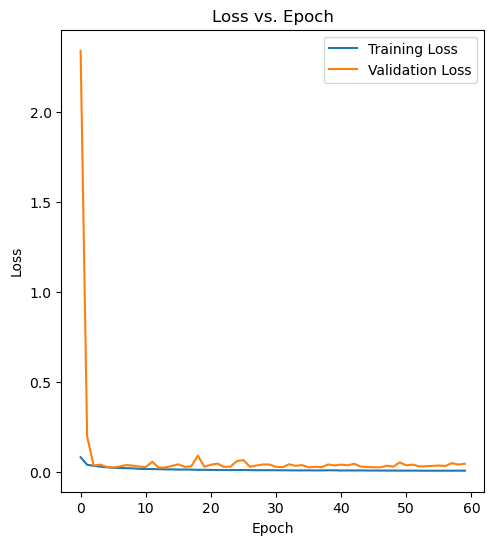

In [17]:
import pickle

# Eğitim geçmişini yükleyin
with open('training_history_half_unet_110_32_60_005.pkl', 'rb') as history_file:
    history = pickle.load(history_file)
    
# Eğitim geçmişini görselleştirme
# İki grafik için subplot oluşturun
plt.figure(figsize=(12, 6))

# Eğitim ve doğrulama kayıplarını ilk grafikte çizin
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epoch')

plt.show()